In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sunxin/minico

1.13.2
2.2.4


Using TensorFlow backend.


In [2]:
import os
import numpy as np
from keras import models
from keras import layers
from keras import optimizers
from keras.datasets import cifar10
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)
x = layers.Conv2D(256, 5, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(256, 4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(channels, 7, activation="tanh", padding="same")(x)
generator = models.Model(generator_input, x)
generator.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv

In [4]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation="sigmoid")(x)
discriminator = models.Model(discriminator_input, x)
discriminator.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
___________________________

In [5]:
discriminator_optimizer = optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss="binary_crossentropy")

In [6]:
discriminator.trainable = False
gan_input = layers.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = models.Model(gan_input, gan_output)
gan_optimizer = optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss="binary_crossentropy")

In [7]:
(X_train, y_train), (_, _) = cifar10.load_data()
X_train = X_train[y_train.flatten() == 6]
X_train = X_train.astype("float32") / 255

In [8]:
iterations = 10000
batch_size = 20
start = 0
for step in range(iterations):
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    generated_images = generator.predict(random_latent_vectors)
    stop = start + batch_size
    real_images = X_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)
    d_loss = discriminator.train_on_batch(combined_images, labels)
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    misleading_targets = np.zeros((batch_size, 1))
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    start += batch_size
    if start > len(X_train) - batch_size:
        start = 0
    if step % 100 == 0:
        gan.save_weights('gan.h5')
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

Instructions for updating:
Use tf.cast instead.


/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 0: 0.6919384
adversarial loss at step 0: 0.71668017
discriminator loss at step 100: 0.7131381
adversarial loss at step 100: 0.7869554
discriminator loss at step 200: 0.7112702
adversarial loss at step 200: 0.8200281
discriminator loss at step 300: 0.7075728
adversarial loss at step 300: 0.74953264
discriminator loss at step 400: 0.69697696
adversarial loss at step 400: 0.73675
discriminator loss at step 500: 0.70237386
adversarial loss at step 500: 0.750054
discriminator loss at step 600: 0.6905022
adversarial loss at step 600: 0.73950845
discriminator loss at step 700: 0.6929313
adversarial loss at step 700: 0.73925817
discriminator loss at step 800: 0.6971625
adversarial loss at step 800: 0.7642764
discriminator loss at step 900: 0.6789161
adversarial loss at step 900: 5.6672926
discriminator loss at step 1000: 0.72524756
adversarial loss at step 1000: 0.7159003
discriminator loss at step 1100: 0.69744253
adversarial loss at step 1100: 1.8990543
discriminat

discriminator loss at step 9700: 0.6822346
adversarial loss at step 9700: 0.84084356
discriminator loss at step 9800: 0.7057742
adversarial loss at step 9800: 0.8506592
discriminator loss at step 9900: 0.74362624
adversarial loss at step 9900: 0.91945875


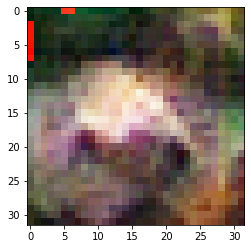

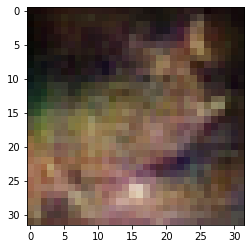

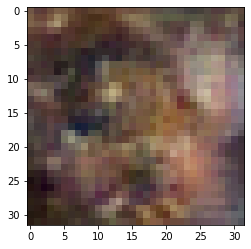

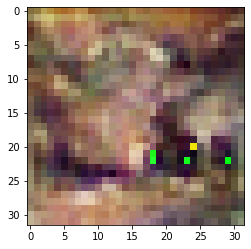

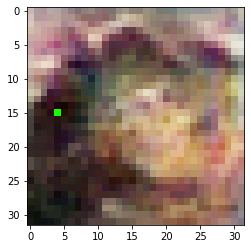

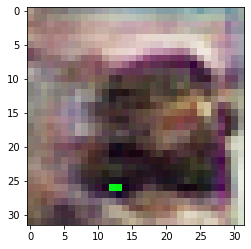

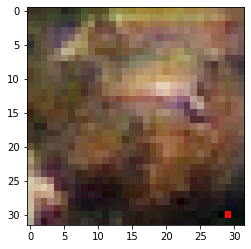

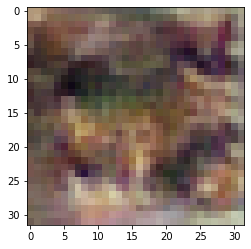

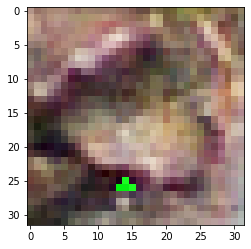

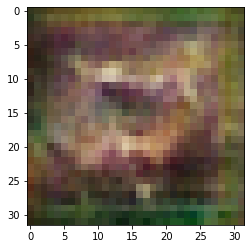

In [9]:
random_latent_vectors = np.random.normal(size=(10, latent_dim))
generated_images = generator.predict(random_latent_vectors)
for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
plt.show()